## Aprendizaje No Supervisado DiploDatos

Práctico entregable:

Utilizar la base de jugadores “players_21.csv” disponible en la página de Kaggle https://www.kaggle.com/stefanoleone992/fifa-21-complete-player-dataset?select=players_21.csv. Considerar que la base 2021 no tiene el mismo formato que la base vista en clase, a los nombres de las variables se les agregó una keyword para identificar a qué tipo de habilidad corresponde.

Con la nueva base, realizar un análisis análogo al que realizamos en el cursado de la materia con los datos FIFA2019 (Basarse en las notebooks ntb_clustering_1_fifa2019_Colab, ntb_clustering_2_fifa2019_Colab y ntb4_embeddings_fifa2019_Colab). Realicen comentarios en cada parte (verbose=True ;))

1- Análisis exploratorio (sintético, no muy extenso) .

2- Evaluación visual e intuitiva de a dos variables por vez.

3- Uso de técnicas de clustering: k-Medias, Mean Shift y Alguna jerárquica (sugerencia: usar 'cityblock' como distancia en el jerárquico).

4- Análisis de los clusters encontrados.

5- Embeddings y técnicas de clustering.

6- Evaluación.

7- Pregunta: ¿Se realizó alguna normalización de la base? ¿Por qué ?

### Inicialización de entorno

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

from sklearn import (manifold, preprocessing, decomposition)
import time

## 1- Exploración de los datos

In [2]:
df=pd.read_csv("players_21.csv")
df.head(3)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,Messi,Yes,138400000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",CAM,10.0,NaN,2004-07-01,2021.0,RW,10.0,85.0,92.0,91.0,95.0,38.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (AI), Speed Drib...",85,95,70,91,...,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,NaN,35,24,6,11,15,14,8,89+3,89+3,89+3,92+0,93+0,93+0,93+0,92+0,93+0,93+0,93+0,91+2,87+3,87+3,87+3,91+2,66+3,65+3,65+3,65+3,66+3,62+3,52+3,52+3,52+3,62+3
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,35,1985-02-05,187,83,Portugal,Juventus,Italian Serie A,1.0,92,92,46000000,220000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,75900000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...",LS,7.0,NaN,2018-07-10,2022.0,LS,7.0,89.0,93.0,81.0,89.0,35.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Flair, Long Shot Taker (AI), ...",84,95,90,82,...,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,NaN,32,24,7,11,15,14,11,91+1,91+1,91+1,89+0,91+0,91+0,91+0,89+0,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,54+3,54+3,54+3,61+3
2,200389,https://sofifa.com/player/200389/jan-oblak/210002,J. Oblak,Jan Oblak,27,1993-01-07,188,87,Slovenia,Atlético Madrid,Spain Primera Division,1.0,91,93,75000000,125000,GK,Right,3,3,1,Medium/Medium,PLAYER_BODY_TYPE_259,Yes,159400000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,90.0,52.0,90.0,"GK Long Throw, Comes For Crosses",13,11,15,43,...,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,NaN,12,18,87,92,78,90,90,33+3,33+3,33+3,32+0,35+0,35+0,35+0,32+0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3


El dataset contiene datos del juego FIFA para consolas. En particular, contiene las estadísticas con las que cuenta cada uno de los jugadores y que definen su comportamiento en el juego.

Como se puede ver debajo, las variables incluyen el nombre del jugador y sus datos físicos, como altura y peso, en que club juega y luego variables referidas a sus habilidades futbolísticas.

El objetivo de este análisis es estudiar si jugadores que juegan en una misma posición comparten características, y si los algoritmos de clusterización podrán identificar estas similitudes

https://sofifa.com/player/158023/lionel-messi/220006/

Overall es una medida resumen de las habilidades de los jugadores. Podemos ver que los valores se ubican entre 0 y 100.

Text(0.5, 1.0, 'Distribución de Overall')

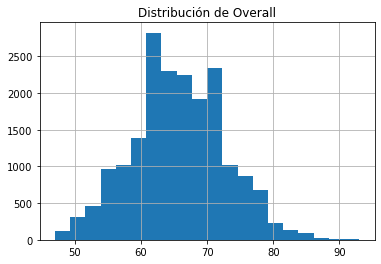

In [3]:
df['overall'].hist(bins = 20).set_title('Distribución de Overall')

Para cada una de las posiciones de los jugadores buscamos el mejor jugador de acuerdo a overall

In [4]:
best_players_per_position=df.iloc[df.groupby(df['team_position'])['overall'].idxmax()][['team_position','short_name','overall']]
best_players_per_position.sort_values(by='overall', ascending=False)

,team_position,short_name,overall
0,CAM,L. Messi,93
1,LS,Cristiano Ronaldo,92
2,GK,J. Oblak,91
3,ST,R. Lewandowski,91
5,RCM,K. De Bruyne,91
4,LW,Neymar Jr,91
8,LCB,V. van Dijk,90
11,RW,M. Salah,90
13,SUB,S. Agüero,89
17,CDM,Casemiro,89


Si observamos la cantidad de jugadores pertenecientes a cada una de las posiciones, vemos que las clases están desbalanceadas. Mientras que RES y SUB cuentan con miles de observaciones, CF solo cuenta con 13.

<AxesSubplot:>

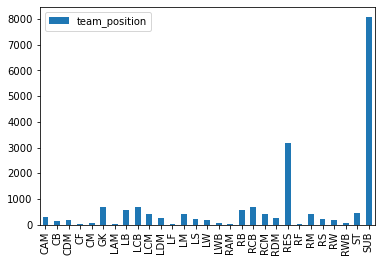

In [5]:
# Conteo de posiciones
pd.DataFrame(df.team_position.value_counts().sort_index()).plot.bar()

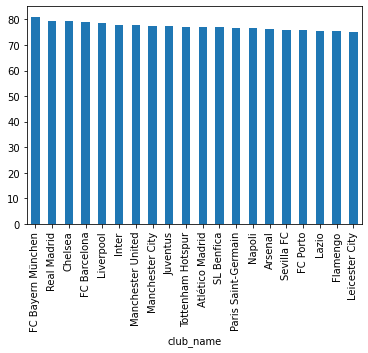

In [6]:
club_avg_overall=df.groupby("club_name")["overall"].mean().sort_values(ascending=False).head(20).plot.bar()


Se puede observar que los clubes con mejor promedio de rating de jugadores son el Bayern Münich y el Real Madrid

Text(0.5, 1.0, 'Distribución de skills')

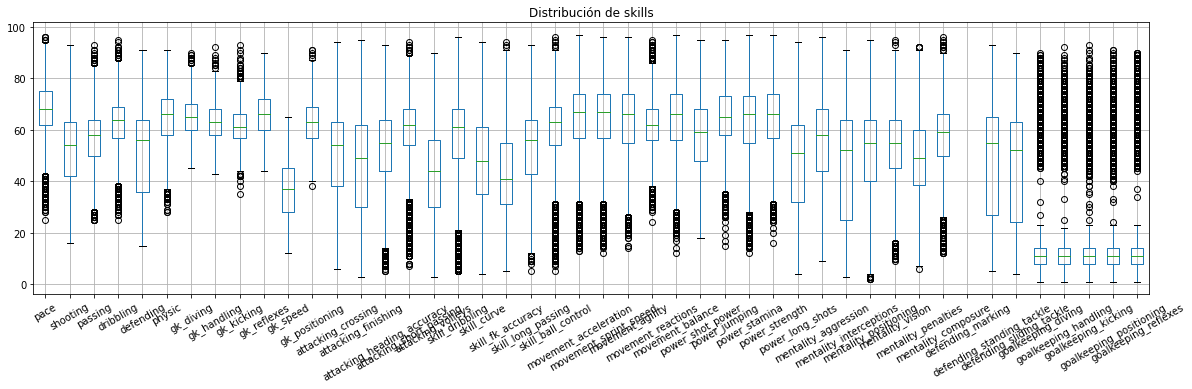

In [7]:
skills_ratings = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'player_traits', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']
df[skills_ratings].boxplot(figsize=(20,5),rot=30).set_title('Distribución de skills')


En el gráfico anterior podemos ver que las variables de skills se mueven entre 0 y 100. Mientras que en algunas variables la cantidad de outliers es numerosa, indicando quizás que pertenecen a un grupo donde ese skill es muy valioso o muy poco útil, en otros casos la distribución es más concentrada.

<AxesSubplot:title={'center':'Age from all database'}, xlabel='age'>

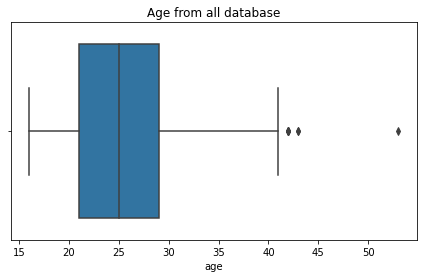

In [8]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title("Age from all database")
sns.boxplot(df.age)

En cuanto a la edad de los jugadores, vemos que ek 50% de los datos se concentra entre los 20 y los 30, con una distribución más alargada hacia mayores edades.

## 2- Preparación de los datos

Retiramos jugadores con bajo desempeño global ("Overall"), reduciendo el tamaño de la base. Se considera variables de desempeño por habilidad (skills_ratings)

In [9]:
df_n=df[df["overall"]> 70] #diferenciamos a los mejores jugadores

print(len(skills_ratings), 'variables numéricas de desempeño según habilidad')

47 variables numéricas de desempeño según habilidad


In [10]:
df_n[skills_ratings].isna().sum()

pace                           444
shooting                       444
passing                        444
dribbling                      444
defending                      444
physic                         444
gk_diving                     4068
gk_handling                   4068
gk_kicking                    4068
gk_reflexes                   4068
gk_speed                      4068
gk_positioning                4068
player_traits                 1033
attacking_crossing               0
attacking_finishing              0
attacking_heading_accuracy       0
attacking_short_passing          0
attacking_volleys                0
skill_dribbling                  0
skill_curve                      0
skill_fk_accuracy                0
skill_long_passing               0
skill_ball_control               0
movement_acceleration            0
movement_sprint_speed            0
movement_agility                 0
movement_reactions               0
movement_balance                 0
power_shot_power    

Podemos ver que muchas variables contienen una cantidad importante de nulos. Como parecen ser nulos en variables que son específicas para una posición, en lugar de rellenarlos con la mediana a los NaNs los rellenaremos con 0, asumiendo que un delantero, por ejemplo, no tiene habilidades de arquero.

Vamos a quedarnos con un subset de los datos, que muestra a los mejores jugadores

In [11]:
df_skills=df_n[skills_ratings] #base, sólo con desempeños según habilidad (numéricas) 
df_skills.drop('player_traits', axis=1, inplace=True)

df_skills=df_skills.dropna(axis='columns')


In [12]:
df_skills.head(4)

,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,35,24,6,11,15,14,8
1,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,32,24,7,11,15,14,11
2,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,12,18,87,92,78,90,90
3,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,42,19,15,6,12,8,10


### Exploratorio Visual para Clustering 

In [13]:
import seaborn as sns

Si vemos los gráficos de dispersión de las variables, podemos ver a simple vista que hay variables que presentan fuertes correlaciones, mientras que otras parecieran no tener ninguna correlación.

In [14]:
# sns.pairplot(df_skills.iloc[:,0:20])
# plt.show()

A través de un mapa de calor podemos observar que hay distintos grupos de variables que parecieran estar ordenadas según posición. En particular, vemos que las que comienzan con gk corresponden a habilidades de arqueros.

In [15]:
# # Mapa de calor para visualización conjunta
# plt.figure(figsize=(18,18))
# correlation_mat = df_skills.corr()

# sns.heatmap(correlation_mat, annot = True)

# plt.show()

Ahora haremos zoom en algunas variables que esperamos generen grupos separados, por ser características de posiciones distintas.

In [20]:
df_skills.columns

Index(['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes'],
      dtype='object')

In [23]:
#data=[]
bool_crack=df_n["overall"] > 85 #diferenciamos a los mejores jugadores

#Elejimos dos variables, para esto elejimos dos números entre 0 y  de n_skills-1
skill_1='movement_sprint_speed'
skill_2='goalkeeping_diving'

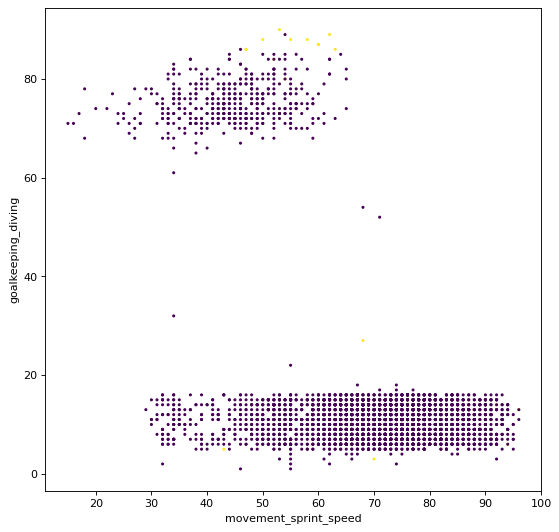

In [24]:
plt.figure(figsize=(8,8), dpi=80)
plt.scatter(df_skills[skill_1], y=df_skills[skill_2],s=3,c=bool_crack)
plt.xlabel(skill_1)
plt.ylabel(skill_2)
plt.show()

En el gráfico anterior podemos diferenciar claramente al grupo de los arqueros (el de la izquierda) del de todas las demás posiciones, que para la habilidad goalkeeping_diving tienen ratings muy bajos.

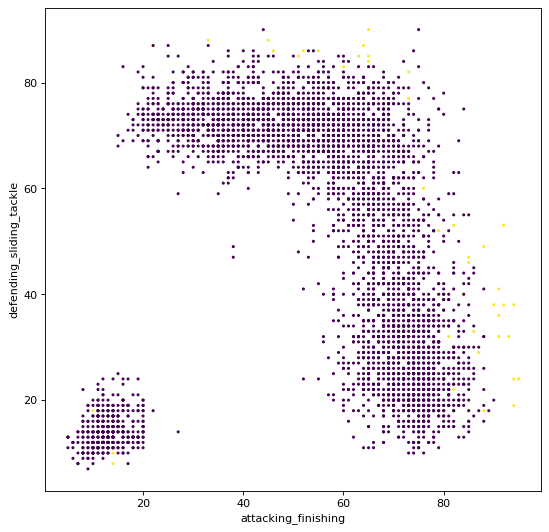

In [25]:
# Otras Pruebas
skill_1 = 'attacking_finishing'
skill_2 = 'defending_sliding_tackle'

plt.figure(figsize=(8,8), dpi=80)
plt.scatter(df_skills[skill_1], y=df_skills[skill_2],s=3,c=bool_crack)
plt.xlabel(skill_1)
plt.ylabel(skill_2)
plt.show()

Teniendo en cuenta las 2 variables elegidas de forma intuitiva (attacking_finishing y defending_sliding_tackle) podemos ver que se segmento bastante bien para lo que podrian ser las posiciones de los jugadores. Por un lado tenemos a los arqueros totalmente separados del resto, lo cual tiene sentido debido a que sus caracteristicas son completamente distintas a las de las otras posiciones. Por el otro lado, tenemos una medialuna en donde la mayoria de los defensores se encuentra en la parte superior, los mediocampistas al medio y los delanteros en la parte inferior derecha


# 3 y 4- Algoritmos de clusterización e interpretación de clusters

## 3a - Clustering con K-means

A continuación haremos la primer clusterización. Como una primera aproximación armaremos 5 clusters y usaremos el algoritmo de k-means.

In [26]:
# Número de clusters buscado
n_clust = 5

km = KMeans(n_clusters=n_clust)
km.fit(df_skills) #utiliza todas las habilidades: 34 dimensiones

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  10156242.343271792


**Elección de la cantidad de grupos/clusters**

Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia.

A través del diagrama de codo vemos que quizás sería mejor utilizar 4 clusters.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

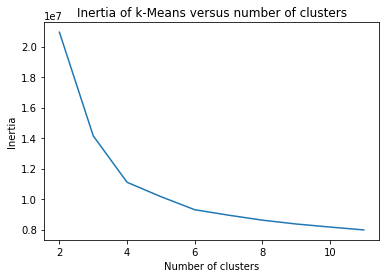

In [27]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [28]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(df_skills) #utiliza todas las habilidades: 34 dimensiones

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  11098843.815338276


**Graficamos el resultado de agrupar a los jugadores usando kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [29]:
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1 = 'attacking_finishing'
skill_2 = 'defending_sliding_tackle'

In [30]:
df_n.columns

Index(['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob',
       'height_cm', 'weight_kg', 'nationality', 'club_name',
       ...
       'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'],
      dtype='object', length=106)

In [31]:
kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                       # text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                     text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

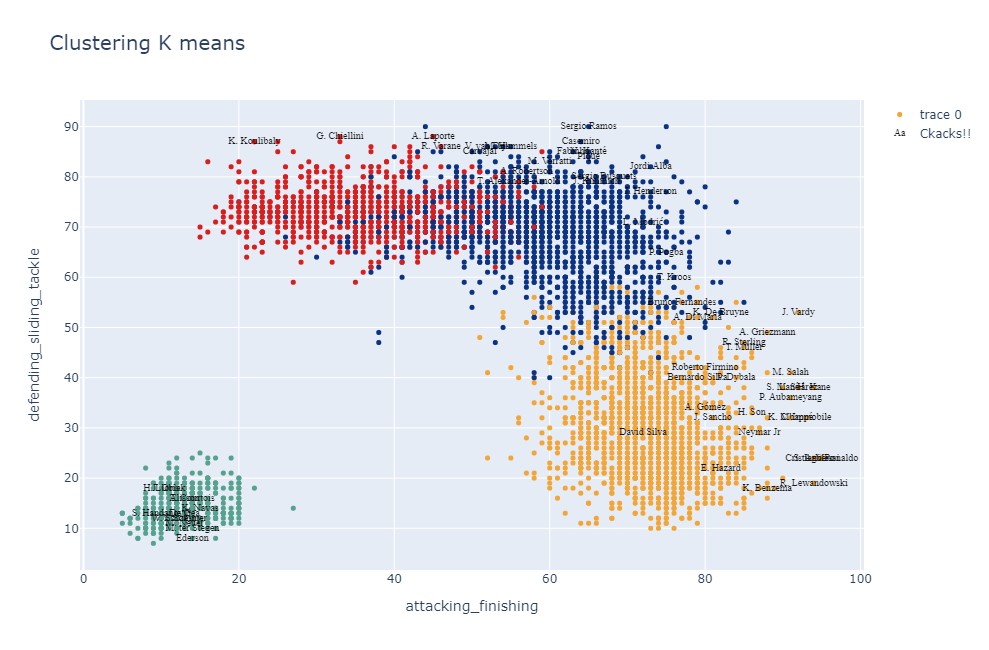

In [32]:
fig.show()

Los jugadores que tienen etiquetas son los que tienen una performance general muy alta.

In [33]:
df_clusters=df_n.copy()
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  4 clusters, nosotros forzamos la cantidad


Utilizando k means, dividiendo el conjunto de datos en 4 clusters, podemos ver que el algoritmo separa muy bien a los jugadores de acuerdo a cada posicion. Si utilizamos las 2 mismas variables intuitivas que elegimos mas arriba para visualizar la clusterizacion, podemos ver que efectivamente separa a los arqueros del resto, y luego deja a los defensores en la parte superior, a los mediocampistas al medio y a los delanteros en la parte inferior derechaEn esta sección pudimos ver que kmeans con 4 clusters hizo una clara separación de los arqueros. A juzgar por los nombres de cada uno de los clusters, la separación encontrada parece dividir mediocampistas de delanteros y defensas.

## 3b - Clustering con Mean-Shift

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio/bandwith (de cobertura para cálculo de media). (Probar con varios)

In [34]:
ms = MeanShift(bandwidth=2, bin_seeding=True)
ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

clusters_encontrados=[]

Cantidad de clusters encontrados por Mean Shift : 3


In [35]:
skill_1 = 'attacking_finishing'
skill_2 = 'defending_sliding_tackle'

In [36]:
data=[]
MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

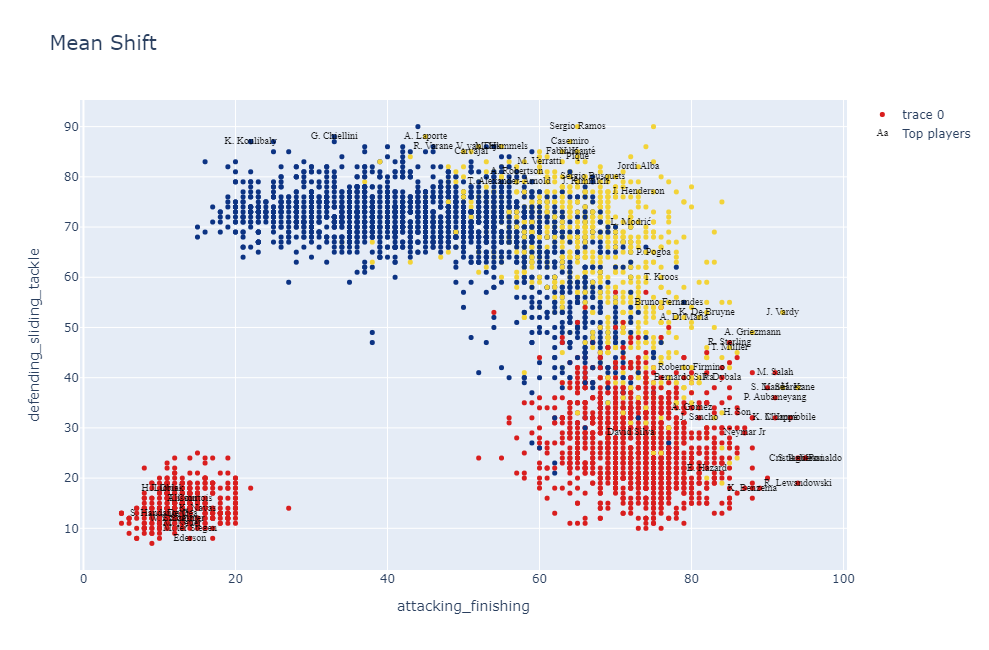

In [37]:

fig.show()

In [38]:
df_clusters['MeanShift'] = ms.labels_ #clusters2
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Kmeans encontró:  4 clusters, nosotros lo forzamos
Mean shift encontró  3 clusters, según los hiperparámetros elegidos


Podemos ver que mean shift encontró 3 clusters (con otro bandwith llegaba a encontrar 4511). Si lo comparamos con el resultado que obtuvimos de KMeans, podemos decir que KMeans hizo un mejor trabajo

## 3c -  Clustering jerárquico


In [39]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

clustering =AgglomerativeClustering(n_clusters=4, linkage='average')
clustering.fit(df_skills)
clustering_2=clustering.labels_
clustering_2

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [40]:
skill_1 = 'attacking_finishing'
skill_2 = 'defending_sliding_tackle'

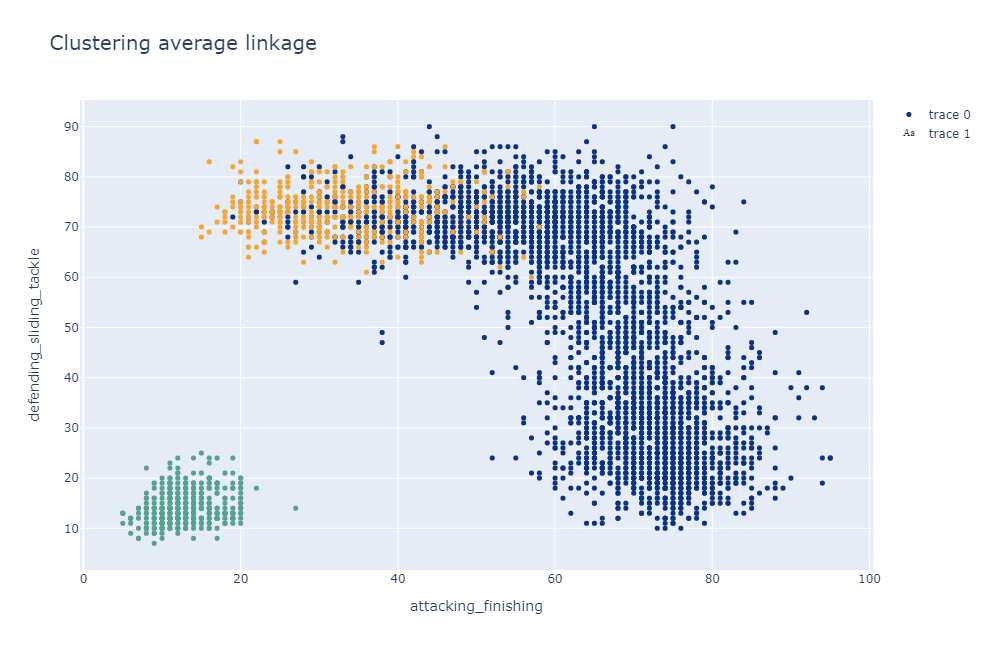

In [44]:
average_linkage_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        
                           marker=dict(
                                size=5,
                                color = clustering_2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],
                      
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[average_linkage_clusters,crack]

layout = go.Layout(title="Clustering average linkage",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)
fig.show()

Para la experimentacion con un algoritmo jerarquico se eligio el average linkage, que como podemos ver , no segmento bien a los mediocampistas y delanteros, en tanto que a los arqueros y defensores si.

## 5 - Visualización con Embeddings

### 5a -  t-SNE

Para realizar el trabajo con embeddings se vuelve a armar el dataset, eligiendo una menor cantidad de datos.

In [46]:
n_sne=2000 #elegir numero pequeño para agilidad en el cálculo luego
df_sne=df.loc[:n_sne]

skills_ratings = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
                  'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning',
                  'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
                  'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
                  'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance',
                  'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
                  'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
                  'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle',
                  'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

X=df_sne[skills_ratings]

X=X[skills_ratings].fillna(value=0) # Relleno NaN con ceros?

print('dimensión del espacio de los datos: ', len(skills_ratings))

dimensión del espacio de los datos:  46


In [47]:
X.head(5)

,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,85.0,92.0,91.0,95.0,38.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,0.0,35,24,6,11,15,14,8
1,89.0,93.0,81.0,89.0,35.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,0.0,32,24,7,11,15,14,11
2,0.0,0.0,0.0,0.0,0.0,0.0,87.0,92.0,78.0,90.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,0.0,12,18,87,92,78,90,90
3,78.0,91.0,78.0,85.0,43.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,0.0,42,19,15,6,12,8,10
4,91.0,85.0,86.0,94.0,36.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,0.0,30,29,9,9,15,15,11


Transformamos el espacio de dim 46 en un espacio de dimensión 2 (n_components=2)

In [48]:
time_start = time.time()

tsne = manifold.TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2001 samples in 0.001s...
[t-SNE] Computed neighbors for 2001 samples in 0.151s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2001
[t-SNE] Computed conditional probabilities for sample 2000 / 2001
[t-SNE] Computed conditional probabilities for sample 2001 / 2001
[t-SNE] Mean sigma: 14.014333
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.905060
[t-SNE] KL divergence after 1000 iterations: 1.283951
t-SNE done! Time elapsed: 9.841268539428711 seconds


Graficamos

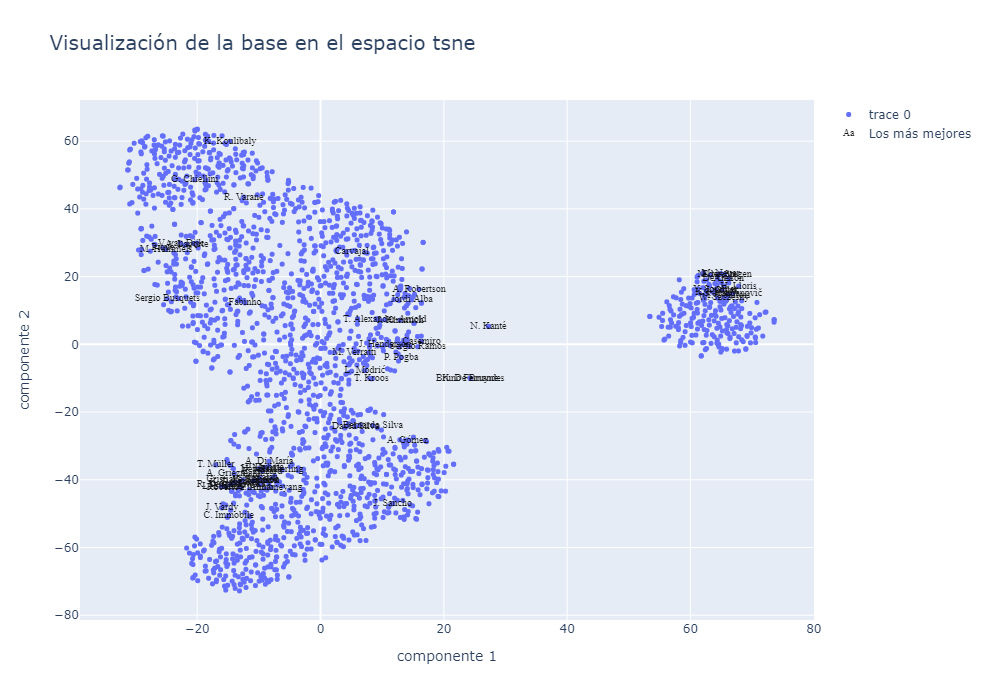

In [50]:
data=[]
bool_crack=df_sne["overall"] > 85 #diferenciamos a los mejores jugadores

#graficamos los datos en el espacio transformado: las dos componentes tsne

graf1 = go.Scatter(x=X_tsne[:,0], y=X_tsne[:,1],
                           mode='markers',
                        text=df_sne.loc[:,'team_position'], #'Height', 'Weight', 'Club', 'Age', 'Name','Position'
                           marker=dict(
                                size=5)
                           )

crack =go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],name='Los más mejores',
                      text=df_sne.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[graf1,crack]

layout = go.Layout(title="Visualización de la base en el espacio tsne",titlefont=dict(size=20),
                xaxis=dict(title='componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=700)

fig = go.Figure(data=data, layout=layout)
fig.show()

**INTERPRETACIÓN**

Al resumir todas las variables en solo dos dimensiones, vemos que nuevamente hay un grupo separado del resto. Quizás este grupo nuevamente este formado por los arqueros. 

Para poner a prueba la intuición o preconcepto de que los jugadores se agrupan en el espacio de las habilidades (transformado/reducido por tsne) según la posición, vamos a crear una nueva columna con 4 categorias de posiciones:

In [51]:
forwards=['RF', 'ST', 'LW', 'LF', 'RS', 'LS', 'RM', 'LM','RW']
midfielders=['RCM','LCM','LDM','CAM','CDM','LAM','RDM','CM','RAM','CF']
defenders=['RCB','CB','LCB','LB','RB','RWB','LWB']
goalkeepers=['GK']

def pos2(position):
    if position in forwards:
        return 'Forward'
    
    elif position in midfielders:
        return 'Midfielder'
    
    elif position in defenders:
        return 'Defender'
    
    elif position in goalkeepers:
        return 'GK'
    
    else:
        return 'nan'

In [52]:
df_sne["team_position2"]=df_sne["team_position"].apply(lambda x: pos2(x))

df_sne["team_position2"].value_counts()

nan           702
Defender      397
Forward       396
Midfielder    355
GK            151
Name: team_position2, dtype: int64

**GRAFICAMOS** 

Las variables que usamos para el scatterplot son las 2 componentes dadas por tSNE

diferenciamos usando vectores booleanos: para cada posición y si es un ckack 

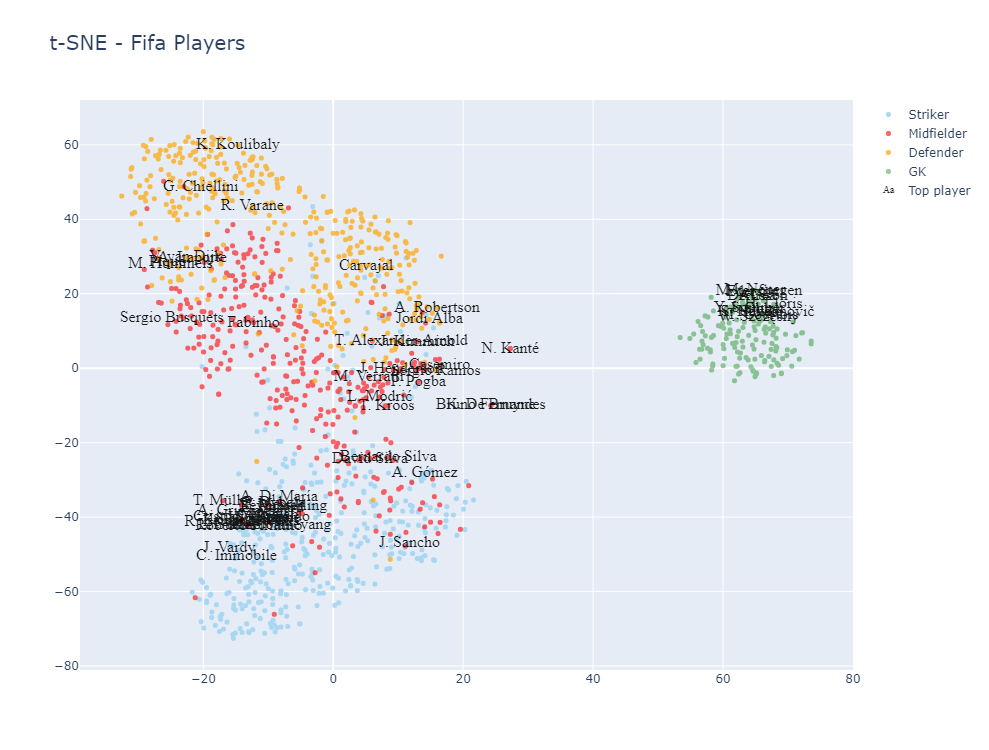

In [53]:
bool_striker= df_sne["team_position2"] == 'Forward'
bool_midfielder= df_sne["team_position2"] == 'Midfielder'
bool_defender= df_sne["team_position2"] == 'Defender'
bool_gk= df_sne["team_position2"] == 'GK'

bool_crack=df_sne["overall"] > 85

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

striker =go.Scatter(x=X_tsne[bool_striker,0], y=X_tsne[bool_striker,1],name='Striker',
                      text=df_sne.loc[bool_striker,'short_name'],
                      opacity=0.9,marker=dict(color=palette[2],size=5),mode='markers')

midfielder =go.Scatter(x=X_tsne[bool_midfielder,0], y=X_tsne[bool_midfielder,1],name='Midfielder',
                      text=df_sne.loc[bool_midfielder,'short_name'],
                      opacity=0.6,marker=dict(color=palette[1],size=5),mode='markers')

defender =go.Scatter(x=X_tsne[bool_defender,0], y=X_tsne[bool_defender,1],name='Defender',
                      text=df_sne.loc[bool_defender,'short_name'],
                      opacity=0.7,marker=dict(color=palette[3],size=5),mode='markers')

gk =go.Scatter(x=X_tsne[bool_gk,0], y=X_tsne[bool_gk,1],name='GK',
                      text=df_sne.loc[bool_gk,'short_name'],
                      opacity=0.4,marker=dict(color=palette[4],size=5),mode='markers')

crack =go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],name='Top player',
                      text=df_sne.loc[bool_crack,'short_name'],textfont=dict(family='sans serif',color='black',size=16),
                      opacity=0.9,mode='text')

data=[striker,midfielder,defender,gk,crack]

layout = go.Layout(title="t-SNE - Fifa Players",titlefont=dict(size=20),
                autosize=False, width=1150,height=750)

fig = go.Figure(data=data, layout=layout)
fig.show()

Como conclusión, podemos ver que en este espacio 2D es realmente muy evidente la separación de los arqueros del resto de los jugadores (lo cual es lógico pues sus habilidades son muy diferentes y era lo que suponíamos al ver el resultado de PCA). 

El agrupamiento visual, en este espacio, de los jugadores no es tan evidente pues los clusters no son disconexos, sino que se entremezclan bastante. Esto significa que las posiciones no explican tan claramente los clusters encontrados.

Una explicación posible puede ser porque hay jugadores ambivalentes que unen los espacios entre defensa, mediocampo y ataque, pero haría falta más conocimiento del tema para llegar a conclusiones más certeras.




### 5b -  Componentes principales

In [54]:
n_acp=18000

df_acp=df.loc[:n_acp]
df_acp=df_acp[(df_acp["team_position"]!='GK')&(df['overall']>70)]

skills_ratings = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
                  'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
                  'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
                  'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance',
                  'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
                  'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
                  'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle']

#otros skills_ratings ! sacamos las habilidades de los arqueros

In [55]:
# Restringimos los datos a las variables numéricas que consideramos

X=df_acp[skills_ratings] # Datos para proyectar
print('los datos tienen dimesión n= ',len(skills_ratings))

los datos tienen dimesión n=  35


**Se computan las componentes principales**

-cuando se usa *decomposition.PCA* : 

La descomposición PCA del sklearn centra los datos pero no los Estandariza (input data is centered but not scaled for each feature before applying the SVD)

por eso **estandarizamos primero**

In [56]:
std_scale=preprocessing.StandardScaler().fit(X)
X_scaled=std_scale.transform(X) # numpyarray Estandarizado (le resta la media y divide por el desvío) por columna

X_scaled = np.nan_to_num(X_scaled, nan=0) # Está bien esto???

In [57]:
print(X_scaled[0:2])
X.head(2)

[[ 1.19739291  2.28243106  2.95327939  2.84205008 -1.1984424  -0.64888226
   1.45238968  2.10744042  0.54621466  2.0334948   1.96609801  1.93145552
   1.93568035  2.33597552  2.26013288  2.1544379   1.5912599   0.79029535
   1.64240975  3.99958671  2.02279766  1.524891   -0.07233358  0.01329386
  -0.060524    1.9989367  -1.54712268 -0.82224355  1.79361661  2.46476405
   1.21634955  3.27755603  0.         -1.04201534 -1.38212736]
 [ 1.52909154  2.35725039  1.72960217  2.13053185 -1.37079238  0.81036299
   1.38888827  2.10744042  1.88346276  1.13574307  1.850108    1.37598576
   1.22214627  1.29662367  1.05962021  1.809669    1.29437859  1.62591043
   1.33469952  4.18315019  0.24244736  2.23233714  2.16672492  0.98589733
   0.71640526  1.94020626 -0.26027248 -1.35603991  1.91126601  1.40790532
   1.8300274   3.14928136  0.         -1.18180853 -1.38212736]]


,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
0,85.0,92.0,91.0,95.0,38.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,NaN,35,24
1,89.0,93.0,81.0,89.0,35.0,77.0,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,NaN,32,24


**DESCOMPOSICIÓN PCA**

En la descomposición podemos elegir n_components para quedarnos con una cantidad chica de componentes 

la idea es que sean "bastante" menos que la dimensión de lo datos pero 

que describan un buen porcentaje de la dispersión de los datos

In [58]:
pca=decomposition.PCA(n_components=4) #elegimos 2, 3 o 4 pero pueden ser más, 

pca.fit(X_scaled) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(X_scaled) #numpy array
print ('tamaño de los datos: ', X_projected.shape)

proporción de varianza por componente:  [0.41517464 0.19222789 0.09845308 0.06960887]
proporción de varianza por componente acumulada:  [0.41517464 0.60740253 0.70585561 0.77546448]
tamaño de los datos:  (4219, 4)


Aplicando PCA, los primeros 4 componentes explican un 77% de la varianza.

In [60]:
pcs=pca.components_  #"composición" de las primeras componentes, 


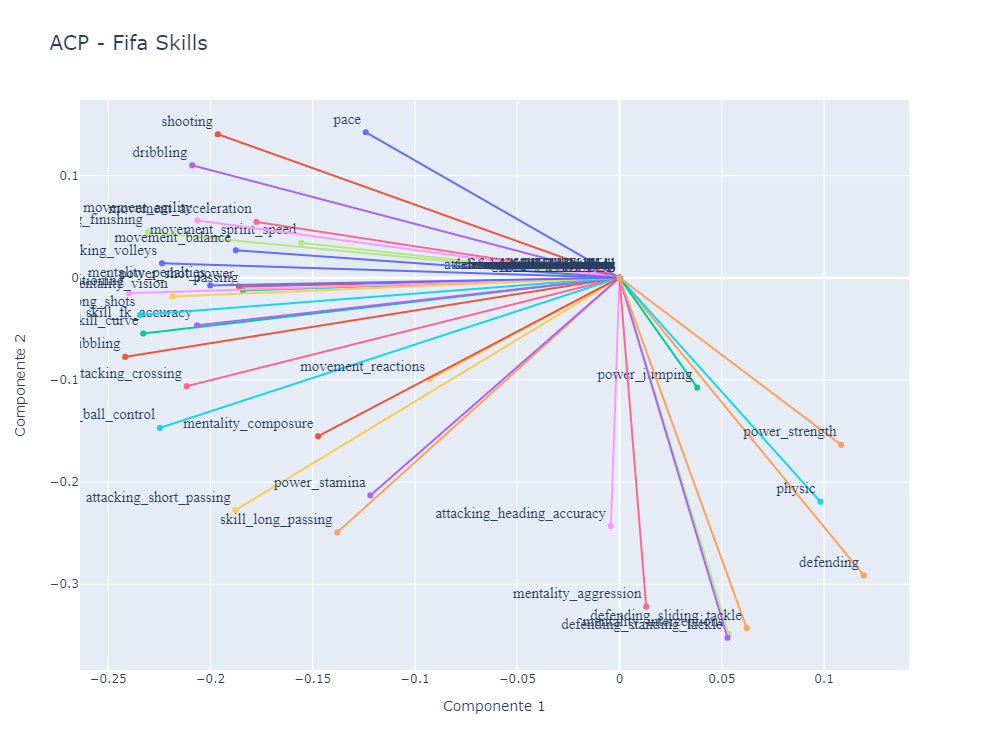

In [61]:
#Graph 1
data=[]

for i, (x,y) in enumerate(zip(pcs[0,:],pcs[1,:])):
    graph=go.Scatter(x=[0,x],y=[0,y],text=X.columns[i],
                     mode='lines+markers+text',textposition='top left',textfont=dict(family='sans serif',size=15))
    data.append(graph)

layout = go.Layout(title="ACP - Fifa Skills",titlefont=dict(size=20),
            xaxis=dict(title='Componente 1'),
            yaxis=dict(title='Componente 2'),
            autosize=False, width=1050,height=750,
            showlegend=False)

fig = go.Figure(data=data, layout=layout)
#plot(fig)
fig.show()

En el gráfico anterior se puede ver que hay variables que tienen más peso que otras en la construcción de los componentes principales. Movement_sprint_speed por ejemplo, influye menos que attacking_finishing.

## 5c -  Clustering

In [64]:
##Hay que quitar MachineGun para Clustering
df_acp=df.loc[:n_acp]
df_acp=df_acp[(df_acp["team_position"]!='GK')&(df['overall']>70)]

X=df_acp[skills_ratings] # Datos sin estandarizar
X_scaled=std_scale.transform(X) # volvemos a normalizar (ya estaba ajustada)

X_scaled = np.nan_to_num(X_scaled, nan=0) # Está bien esto???

X_projected=pca.transform(X_scaled) #volvemos a proyectar 
print('dimensiones de la base proyectada:', X_projected.shape)

dimensiones de la base proyectada: (4219, 4)


In [76]:
X_projected = pd.DataFrame(X_projected)

In [80]:
X_projected.columns = ['PCA1','PCA2','PCA3','PCA4']

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

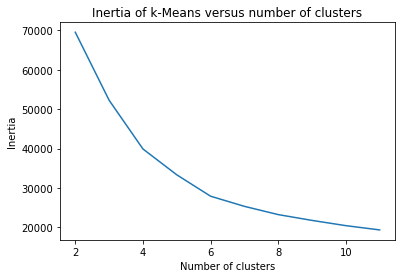

In [77]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(X_projected).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Comenzamos con el diagrama de codo. Quizás en este caso 4 o 6 clusters serían una buena opción.

In [78]:
n_clust = 6

km = KMeans(n_clusters=n_clust)
km.fit(X_projected) #utiliza todas las habilidades: 34 dimensiones

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  27912.030989784096


In [85]:
X_projected[['PCA1','PCA2']]

,PCA1,PCA2
0,-9.912971,0.214904
1,-8.195756,-0.492162
2,-6.668225,-1.225273
3,-9.404773,1.125488
4,-7.881831,-3.053635
...,...,...
4214,-1.079800,3.937921
4215,-1.178032,1.824387
4216,-1.652660,4.008603
4217,-1.674972,-1.748881


<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

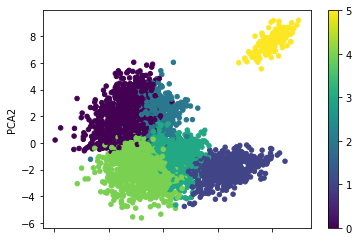

In [92]:
df = X_projected[['PCA1','PCA2']]
df.plot.scatter(x='PCA1', y='PCA2',c=clusters, colormap='viridis'                  
                           )


Con Kmeans podemos ver 6 clusters claramente diferenciados, si bien en los bordes llega a entremezclarse levemente. 

Mean Shift y visualizar en las dos primeras componentes 

In [93]:
ms = MeanShift(bandwidth=2, bin_seeding=False)

ms.fit(X_projected)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 9


<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

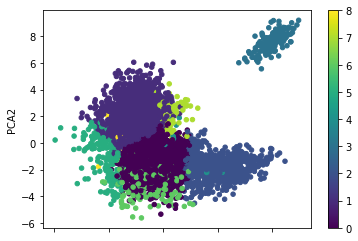

In [94]:
df = X_projected[['PCA1','PCA2']]
df.plot.scatter(x='PCA1', y='PCA2',c=clusters2, colormap='viridis'                  
                           )


En el caso de meanshift, al trabajar con componentes principales encontró 9 clusters. A priori pareciera que algunos son muy pequeños y están entremezclados con los demás, al punto de no ser visibles. Por lo demás, la separación es muy similar a la de KMeans.

## 6) Evaluación

Por la naturaleza de los datos, pareciera ser que los algoritmos de clusterización sobre los datos en crudo tienen una performance aceptable, separando claramente los grandes grupos de jugadores. Si debe mencionarse que la performance de KMeans fue superior a la de MeanShift y a la de la clusterización jerárquica. Sin embargo, las diferencias entre las distintas posiciones pertenecientes a un mismo gran grupo (mediocampistas y sus laterales) no fue detectada adecuadamente por los distintos métodos. 

Luego de procesar los datos con PCA, capturando el 77% de la variación de los datos en solo 4 componentes, los algoritmos ya comienzan a detectar más claramente la separación de los grupos, y en el caso de MeanShift pasa de reconocer 3 clusters a 6 clusters, mientras que el método del codo sugiere que 6 clusters serían más adecuados, cuando antes indicaba 6. En cuanto a la exactitud de la división respecto a las posiciones reales de los jugadores, podemos ver que los arqueros nuevamente están bien separados, mientras que por t-SNE debe mencionarse también que la separación entre posiciones no fue muy clara.

## 7) Normalización


En ningún momento se normalizaron los datos, ya que eso se realiza para datos con gran dispersión. Por la naturaleza del dato, las variables con las que se trabajó se distribuían en todos los casos entre 0 y 100, por lo que la normalización no era necesaria. 